In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
data_path = 'dataset/dataset.csv'
split_data_path = 'data/data_seq/'
#Load the dataset and select a subset whith the predictive features + target + port_call_id (ROW_ID)
df = pd.read_csv(data_path)
df.shape

(155734, 41)

In [11]:
# Split the dataset to train, validation, and test sets 
# Define a list of port calls
port_calls = df.loc[:,'ROW_ID'].unique()

# Define the split indexes using the ratio 5:2.5:2.5
indx_1 = round(len(port_calls)*0.5)
indx_2 = indx_1 + round(len(port_calls)*0.25)

#define the voyages for train, validation, and test sets 
train_calls = port_calls[: indx_1]
valid_calls = port_calls[indx_1 : indx_2+1]
test_calls = port_calls[indx_2 +1 :]

print('The number of examples/voyages in the train set is:', len(train_calls))
print('The number of examples/voyages in the validation set is:', len(valid_calls))
print('The number of examples/voyages in the test set is:', len(test_calls))

#split the data into train, validation, and test 
train = df[df['ROW_ID'].isin(train_calls)]
valid = df[df['ROW_ID'].isin(valid_calls)]
test = df[df['ROW_ID'].isin(test_calls)]

print('')
print('The train set shape is:', train.shape)
print('The validation set shape is:', valid.shape)
print('The test set shape is:', test.shape)

The number of examples/voyages in the train set is: 1417
The number of examples/voyages in the validation set is: 709
The number of examples/voyages in the test set is: 708

The train set shape is: (77122, 41)
The validation set shape is: (38835, 41)
The test set shape is: (39777, 41)


In [12]:
# Define the mean and std of the remaining distance to destination.
rem_dist_train_std= train.remaining_distance.std()
rem_dist_train_mean= train.remaining_distance.mean()

# Standardize the data
scaled_features_train = train.copy()
scaled_features_valid = valid.copy()
scaled_features_test = test.copy()

col_names = ['Max_Draught','Latitude','Longitude','Speed_over_Ground','GT','DWT','LOA','BEAM','COG_cos','COG_sin','TH_cos','TH_sin', 'current_uo', 'current_vo','wind_u10', 'wind_v10',
'mwd', 'mwp', 'swh','sst', 'Age','Origin_Lat','Origin_Lon', 'acc_dist','acc_time_hours','leg_distance','leg_speed','leg_elapsed_time_hours','remaining_distance']

features_train = scaled_features_train[col_names]
features_valid = scaled_features_valid[col_names]
features_test = scaled_features_test[col_names]

scaler = StandardScaler().fit(features_train.values)

features_train = scaler.transform(features_train.values)
features_valid = scaler.transform(features_valid.values)
features_test = scaler.transform(features_test.values)

scaled_features_train[col_names] = features_train
scaled_features_valid[col_names] = features_valid
scaled_features_test[col_names] = features_test


The max length of sequences in the train set is: 65
The max length of sequences in the validation set is: 65
The max length of sequences in the test set is: 65


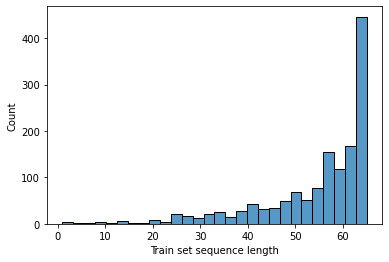

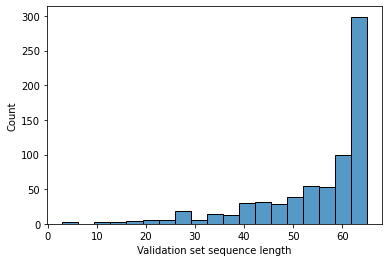

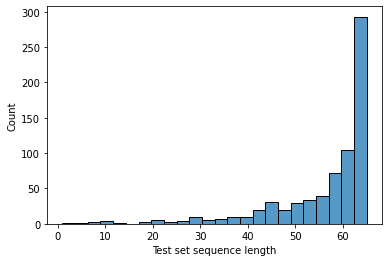

In [8]:
# Define the length of sequences
def return_seq_len(dataset):
  T = []
  voyages = dataset.ROW_ID.unique() 
  for i in range(len(voyages)):
      data = dataset.loc[dataset['ROW_ID'] == voyages[i]]
      T.append(data.shape[0])
  return T

train_seq_len = return_seq_len(scaled_features_train)
valid_seq_len = return_seq_len(scaled_features_valid)
test_seq_len = return_seq_len(scaled_features_test)

print('The max length of sequences in the train set is:', max(train_seq_len))
print('The max length of sequences in the validation set is:', max(valid_seq_len))
print('The max length of sequences in the test set is:', max(test_seq_len))

ax = sns.histplot(train_seq_len)
ax.set(xlabel = 'Train set sequence length')
plt.show()

ax = sns.histplot(valid_seq_len)
ax.set(xlabel = 'Validation set sequence length')
plt.show()

ax = sns.histplot(test_seq_len)
ax.set(xlabel = 'Test set sequence length')
plt.show()

In [9]:
#make sequences
m = max(max(train_seq_len), max(valid_seq_len), max(valid_seq_len))
n_features = df.shape[1] - 2

def make_sequences(set, dataset):
  x =[]
  y =[]

  for i in range(len(set)):
    data = dataset.loc[dataset['ROW_ID'] == set[i]]
    l= m - len(data)
    a = np.array(data.pop('Target'))
    a = np.pad(a,(0,l), 'constant')
    b = np.array(data.drop(['ROW_ID'], axis =1))
    b = np.pad(b, ((0,l),(0,0)), 'constant')
    x.append(b)
    y.append(a)
  x = np.reshape(x, (len(set), m, n_features))
  y = np.reshape(y, (len(set), m))
  return x, y

x_train, y_train = make_sequences(train_calls, scaled_features_train)
x_valid, y_valid = make_sequences(valid_calls, scaled_features_valid)
x_test, y_test = make_sequences(test_calls, scaled_features_test)

y_test = y_test.reshape(708,65,1)
y_train = y_train.reshape(1417,65,1)
y_valid = y_valid.reshape(709,65,1)


print('Max seqquences length is:', m)
print('Number of features is:', n_features)
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_valid is:', x_valid.shape)
print('Shape of y_valid is:', y_valid.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Max seqquences length is: 65
Number of features is: 39
Shape of x_train is: (1417, 65, 39)
Shape of y_train is: (1417, 65, 1)
Shape of x_valid is: (709, 65, 39)
Shape of y_valid is: (709, 65, 1)
Shape of x_test is: (708, 65, 39)
Shape of y_test is: (708, 65, 1)


In [ ]:
np.save(split_data_path + 'x_train', x_train)
np.save(split_data_path + 'x_test', x_test)
np.save(split_data_path + 'x_valid', x_valid)
np.save(split_data_path + 'y_train', y_train)
np.save(split_data_path + 'y_test', y_test)
np.save(split_data_path + 'y_valid', y_valid)

np.save(split_data_path + 'remaining_distance_std_train', rem_dist_train_std)
np.save(split_data_path + 'remaining_distance_mean_train', rem_dist_train_mean)

np.save(split_data_path + 'train_sequence_length', train_seq_len)
np.save(split_data_path + 'valid_sequence_length', valid_seq_len)
np.save(split_data_path + 'test_sequence_length', test_seq_len)